# DCGAN

## GAN原理

<img src="GAN.png" width="35%">

### 生成网络G(z)：

从先验分布$p_z(\cdot)$中采样隐藏变量$z\sim p_z(\cdot)$（如生成符合正态分布的数据），通过生成对抗网络G**参数化后**的分布$p_g(x|z)$，获得生成样本$x$，$x\sim p_g(x|z)$。生成器G的功能是将隐向量$z$通过神经网络转换为样本向量$x_{f}$。

### 判别网路D(x)：

判别网络和普通的二分类网络功能类似，它接受输入样本$x$的数据集，包含了采样自真实数据分布$p_r(\cdot)$的样本$x_r\sim p_r(\cdot)$，也包括了采样自生成网络的假样本$x_f\sim p_g(x|z)$。$x_r$的训练标签为真(1)，$x_f$的训练标签为假(0)，判别网络输出$x$属于真实样本的概率$P(x\  is\  real|x)$，，通过最小化判别网络$D$的预测值与标签之间的误差来优化判别网络参数。

### 度量方法

#### 信息熵

1948年，Claude Shannon 将热力学中熵的概念引入到信息论中，用来衡量信息的不确定度。熵在信息学科中也叫**信息熵**，或者香农熵。**熵越大，代表不确定性越大，信息量也就越大。**某个分布𝑃(𝑖)的熵定义为

$$
H(P)\triangleq -\sum_iP(i)\log_2P(i)
$$

实际上，$H(P)$也可以使用其他底数的log函数计算。

举个例子，对于 4 分类问题，如果某个 样本的真实标签是第 4 类，那么标签的One-hot 编码为\[0,0,0,1\]，即这张图片的分类是唯一 确定的，它属于第4类的概率$P(y=4|x)=1$，不确定性为0，它的熵可以简单的计算为：

$$
-0\cdot \log_2 0-0\cdot \log_2 0-0\cdot \log_2 0-1\cdot \log_2 1 =0
$$

也就是说，对于确定的分布，熵为0，不确定性最低。

如果它预测的概率分布是\[0.1,0.1,0.1,0.7\]，它的熵可以计算为：

$$
-0.1\cdot \log_2 0.1 - 0.1 \cdot\log_2 0.1 - 0.1 \cdot log_2 0.1 - 0.7 \cdot log_2 0.7 \approx 1.356
$$

这种情况比前面的例子的不确定性要稍微大点。

考虑随机分类器，它每个类别的预测概率是均等的：\[0.25,0.25,0.25,0.25\]，同样的方法，可以计算它的熵约为2，这种情况的不确定性略大于上面一种情况。

由于$P(i)\in [0,1],\log_2 P(i)\leq 0$，因此熵$H(P)$总是大约等于0。当熵取得最小值0时，不确定性为0。分类问题的One-hot编码的分布就是熵为0的典型例子。在TensorFlow中间，我们可以利用`tf.math.log`来计算熵。

#### 交叉熵误差函数

基于熵引出交叉熵(Cross Entropy)的定义：

$$
H(p||q) \triangleq -\sum_i p(i)\log_2 q(i)
$$

通过**简单变换**，交叉熵可以分解为$p$的熵$H(p)$和$p$与$q$的$KL$散度(Kullback-Leibler Divergence)的和：

$$
H(p||q) \triangleq H(p)+D_{KL}(p||q)
$$

其中$KL$定义为

$$D_{KL}(p||q) \triangleq \sum_i p(i)\log_2({p(i)\over q(i)}) 
$$

$KL$散度是 Solomon Kullback 和Richard A. Leibler 在1951年提出的**用于衡量2个分布之间距离的指标**。$𝑝 = 𝑞$时，$D_{KL}(p||q)$取得最小值0，$p$与$q$之间的差距越大，$D_{KL}(p||q)$也越大。需要注意的是，交叉熵和KL散度都不是对称的，即：

$$
H(p||q)\neq H(q||p)\\
D_{KL}(p||q)\neq D_{KL}(q||p)
$$

在实现中，真实样本分布概率为$p$。

交叉熵可以很好地衡量 2 个分布之间的“距离”。特别地，当分类问题中$y$的编码分布$p$采用One-hot编码$y$时：$H(p)=0$，此时

$$
H(p||q)=H(p)+D_{KL}(p||q)=D_{KL}(p||q)
$$

退化到真实标签分布$y$与输出概率分布$o$之间的$KL$散度上。


根据$KL$散度的定义，我们推导分类问题中交叉熵的计算表达式：

$$
H(p||q)=D_{KL}=\sum_{j}y_i\log_2({y_i\over o_j})\\
=1\cdot{1\over o_i}+\sum_{j\leq i}0\cdot \log({0\over o_j})\\
=-\log o_i
$$

其中$i$为One-hot编码中为1的索引号，也是当前输入的真实类别。可以看到，$\mathcal{L}$（损失函数）只与真实类别$i$上的概率$o_i$有关，对应概率$o_i$越大，$H(p||q)$越小。当对应类别上的概率为1时，交叉熵$H(p||q)$取得最小值0，此时网络输出$o$与真实标签$y$完全一致，神经网络取得最优状态。

因此最小化交叉熵损失函数的过程也是最大化正确类别的预测概率的过程。从这个角度去理解交叉熵损失函数，非常地直观易懂。

参考链接:[如何通俗的解释交叉熵与相对熵? - CyberRep的回答 - 知乎](https://www.zhihu.com/question/41252833/answer/195901726)


### 网络训练：

由于生成器G和判别器D的优化目标不一样，不能和之前的网络模型的训练一样，只采用一个损失函数。

#### 判别网络：

对于判别网络D，它的目标是能够很好地分辨出真样本$x_r$与假样本$x_f$。以图片生成为例，它的目标是**最小化图片的预测值和真实值之间的交叉熵损失函数**：

$$
min_{\theta} L=CE(D_{\theta}(x_r),y_r, D_{\theta}(x_f),y_f)
$$

$\theta$为判别网络参数，$D_{\theta}(x)$为输出概率，$y$为标签，CE为交叉熵损失函数CrossEntropy。

二分类问题的交叉熵损失函数定义为：

$$
\mathcal{L}=-\sum_{x_r\sim p_r(\cdot)}\log D_{\theta}(x_r)-\sum_{x_f\sim p_g(\cdot)}\log (1-D_{\theta}(x_f))
$$

因此判别网络D的优化目标是：
$$
\theta^{*}=argmin_{\theta} -\sum_{x_r\sim p_r(\cdot)}\log D_{\theta}(x_r)-\sum_{x_f\sim p_g(\cdot)}\log (1-D_{\theta}(x_f))
$$

把$min_{\theta}\mathcal{L}$问题转换为$max_{\theta}-\mathcal{L}$，并写成期望形式：

$$
\theta^{*}=argmax_{\theta} E_{x_r\sim p_r(\cdot)}\log D_{\theta}(x_r)+E_{x_f\sim p_g(\cdot)}\log (1-D_{\theta}(x_f))
$$

#### 生成网络

对于生成网络G(z)，我们希望$x_f = G_{z}$能够很好地骗过判别网络D，假样本$x_f$在**判别网络的输出越接近真实标签越好**。也就是说，在训练生成网络时，希望判别网络的输出𝐷(𝐺(𝒛))越逼近1越好，最小化$D(G(z))$与1之间的交叉熵损失函数：

$$
min_{\phi}\mathcal{L}=CE(D(G_{\phi}(z)),1)=-\log D(G_{\phi}(z))
$$

等价转化为：

$$
\begin{aligned}
\phi^*=&argmax_{\phi}E_{z\sim p_z(\cdot)}\log D(G_{\phi}(z))\\
=&argmin_{\phi}E_{z\sim p_z(\cdot)}\log[1- D(G_{\phi}(z))]
\end{aligned}
$$

#### 统一目标函数

我们把判别网络的目标和生成网络的目标合并，写成min - max博弈形式：

(这也是上面一个求最大值，一个求最小值的原因)

$$
\begin{aligned}
min_{\phi} max_{\theta}\mathcal{L}(D,G)&=E_{x_r\sim p_r(\cdot)}\log D_{\theta}(x_r)+E_{x_f\sim p_g(\cdot)}\log (1-D_{\theta}(x_f))\\
&=E_{x_r\sim p_r(\cdot)}\log D_{\theta}(x_r)+E_{z\sim p_z(\cdot)}\log (1-D_{\theta}(G_{\phi}(z)))
\end{aligned}
$$

#### 算法流程

<img src="GAN_alg.png" width="50%">

在TensorFlow实现中，可以采用

```python
with tf.GradientTape() as tape:
    #...
tape.gradient()
```

都可以使用梯度下降实现，本质就是交叉熵最小，统一为min - max博弈形式主要出于数学表达的角度。

## DCGAN

### 结构

<img src="DandG.png">

### 实现

见代码间注释

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,optimizers,losses,datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_moons 
from sklearn.model_selection import train_test_split
from PIL import Image
import imageio
import  glob

加载数据集。

这里使用的是一组二次元动漫头像的数据集，共51223张图片，无标注信息，图片主体已裁剪、对齐并统一缩放到96 × 96大小。

<img src="carton.png" width="60%">

数据对象处理在dataset模块。

In [ ]:
from dataset import make_anime_dataset

#读取数据集路径，从https://pan.baidu.com/s/1eSifHcA 提取码：g5qa 下载解压
img_path=glob.glob(r'faces/*.jpg')
#glob是python自己带的一个文件操作相关模块，用它可以查找符合自己目的的文件
#glob模块的主要方法就是glob,该方法返回所有匹配的文件路径列表（list）；
#该方法需要一个参数用来指定匹配的路径字符串（字符串可以为绝对路径也可以为相对路径），其返回的文件名只包括当前目录里的文件名，不包括子文件夹里的文件。
batch_size=128
dataset,img_shape,_=make_anime_dataset(img_path, batch_size=batch_size,resize=64)
#其中dataset对象就是tf.data.Dataset类实例，已经完成了随机打散、预处理和批量化等操作，可以直接迭代获得样本批，img_shape是预处理后的图片大小。
dataset=dataset.repeat(300)

**生成器**

生成网络G由 5 个转置卷积层单元堆叠而成，实现特征图高宽的层层放大，特征图通道数的层层减少。

首先将长度为100的隐藏向量𝒛通过Reshape操作调整为\[𝑏, 1,1,100\]的4维张量，

并依序通过转置卷积层，放大高宽维度，减少通道数维度，最后得到高宽为 64，通道数为3的彩色图片。

每个卷积层中间插入BN层来提高训练稳定性，卷积层选择不使用偏置向量。

In [2]:
class Generator(keras.Model):
    #生成器网络类
    def __init__(self):
        super(Generator,self).__init__()
        filter=64
        #转置卷积层1，输出channel为filter*8,核大小4，步长1,不使用padding，不使用偏置
        #当设置 padding=’VALID’时，输出大小表达为：o=(i-1)s+k
        self.conv1=layers.Conv2DTranspose(filter*8,4,1,'valid',use_bias=False)
        self.bn1=layers.BatchNormalization()
        #转置卷积层2
        self.conv2=layers.Conv2DTranspose(filter*4,4,2,'same',use_bias=False)
        self.bn2=layers.BatchNormalization()
        #转置卷积层3
        self.conv3=layers.Conv2DTranspose(filter*2,4,2,'same',use_bias=False)
        self.bn3=layers.BatchNormalization()
        #转置卷积层4
        self.conv4=layers.Conv2DTranspose(filter*1,4,2,'same',use_bias=False)
        self.bn4=layers.BatchNormalization()
        #转置卷积5
        self.conv5=layers.Conv2DTranspose(3,4,2,'same',use_bias=False)
        
    def call(self,inputs,training=None):
        x=inputs #[z,100]
        #Reshape为[b,1,1,100]
        x=tf.reshape(x,(x.shape[0],1,1,x.shape[1]))
        x=tf.nn.relu(x)
        #转置卷积-BN-激活函数[b,4,4,512]
        x=tf.nn.relu(self.bn1(self.conv1(x),training=training))
        #转置卷积-BN-激活函数[b,8,8,256]
        x=tf.nn.relu(self.bn2(self.conv2(x),training=training))
        #转置卷积-BN-激活函数[b,16,16,128]
        x=tf.nn.relu(self.bn3(self.conv3(x),training=training))
        #转置卷积-BN-激活函数[b,32,32,64]
        x=tf.nn.relu(self.bn4(self.conv4(x),training=training))
        #转置卷积-激活函数[b,64,64,3]
        x=self.conv5(x)
        x=tf.tanh(x)#输出x范围为-1~1，与预处理一致
        
        return x

**判别器**

判别网络D与普通的分类网络相同，

接受大小为\[𝑏,64,64,3\]的图片张量，

连续通过5个卷积层实现特征的层层提取，

卷积层最终输出大小为\[𝑏, 2,2,1024\]，

再通过池化层 GlobalAveragePooling2D将特征大小转换为\[𝑏, 1024\]，

最后通过一个全连接层获得二分类任务的概率。

In [3]:
class Discriminator(keras.Model):
    #判别器类
    def __init__(self):
        super(Discriminator,self).__init__()
        filter=64
        #卷积层1
        self.conv1=layers.Conv2D(filter,4,2,'valid',use_bias=False)
        self.bn1=layers.BatchNormalization()
        #卷积层2
        self.conv2=layers.Conv2D(filter*2,4,2,'valid',use_bias=False)
        self.bn2=layers.BatchNormalization()
        #卷积层3
        self.conv3=layers.Conv2D(filter*4,4,2,'valid',use_bias=False)
        self.bn3=layers.BatchNormalization()
        #卷积层4
        self.conv4=layers.Conv2D(filter*8,3,1,'valid',use_bias=False)
        self.bn4=layers.BatchNormalization()
        #卷积层5
        self.conv5=layers.Conv2D(filter*16,3,1,'valid',use_bias=False)
        self.bn5=layers.BatchNormalization()
        #全局池化层
        self.pool=layers.GlobalAveragePooling2D()
        #特征打平层
        self.flatten=layers.Flatten()
        #二分类全连接层
        self.fc=layers.Dense(1)
        
    def call(self,inputs,training=None):
        #卷积-BN-激活函数:(4,31,31,64)
        # 卷积-BN-激活函数:(4, 31, 31, 64)
        
        x = tf.nn.leaky_relu(self.bn1(self.conv1(inputs), training=training))
        # 卷积-BN-激活函数:(4, 14, 14, 128)
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        # 卷积-BN-激活函数:(4, 6, 6, 256)
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        # 卷积-BN-激活函数:(4, 4, 4, 512)
        x = tf.nn.leaky_relu(self.bn4(self.conv4(x), training=training))
        # 卷积-BN-激活函数:(4, 2, 2, 1024)
        x = tf.nn.leaky_relu(self.bn5(self.conv5(x), training=training))
        # 卷积-BN-激活函数:(4, 1024)
        x = self.pool(x)
        # 打平
        x = self.flatten(x)
        # 输出，[b, 1024] => [b, 1]
        logits = self.fc(x)

        return logits      
    
        #判别器的输出大小为[𝑏, 1]，类内部没有使用 Sigmoid 激活函数，
        #通过 Sigmoid 激活函数后 可获得𝑏个样本属于真实样本的概率

计算损失函数，用信息熵交叉函数实现。

In [3]:
help(keras.losses.binary_crossentropy)

Help on function binary_crossentropy in module tensorflow.python.keras.losses:

binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)



In [ ]:
def celoss_zeros(logits):
    # 计算属于与便签为0的交叉熵
    y = tf.zeros_like(logits)
    loss = keras.losses.binary_crossentropy(y, logits, from_logits=True)
    return tf.reduce_mean(loss)

def celoss_ones(logits):
    # 计算属于与标签为1的交叉熵
    y = tf.ones_like(logits)
    loss = keras.losses.binary_crossentropy(y, logits, from_logits=True)
    return tf.reduce_mean(loss)

In [ ]:
def d_loss_fn(generator,discriminator,batch_z,batch_x,is_training):
    #计算判别器的误差函数
    #采样生成图片
    fake_image=generator(batch_z,is_training)
    #判定生成图片
    d_fake_logits=discriminator(fake_image,is_training)
    #判定真实图片
    d_real_logits=discriminator(batch_x,is_training)
    #真实图片与1之间的误差
    d_loss_real=celoss_ones(d_real_logits)
    #生成图片与0之间的误差
    d_loss_fake=celoss_zeros(d_fake_logits)
    #合并误差
    loss=d_loss_fake+d_loss_real
    
    return loss

In [ ]:
def g_loss_fn(generator,discriminator,batch_z,is_training):
    #采样生成图片
    fake_image=generator(batch_z,is_training)
    #训练生成网络时，需要迫使生成图片判定为真
    d_fake_logits=discriminator(fake_image,is_training)
    #计算生成图片与1之间的误差
    loss=celoss_ones(d_fake_logits)
    
    return loss

网络训练，需要调节超参数。

In [ ]:
def main():
    z_dim=100#隐藏变量z的维度
    
    generator=Generator()#创建生成器
    generator.build(input_shape=(batch_size,z_dim))
    generator.summary()
    discriminator=Discriminator()#创建判别器
    discriminator.build(input_shape=(None,64,64,3))
    discriminator.summary()
    #分别为生成器和判别器创建优化器
    
    if os.path.exists('checkpoint')==True:
        generator.load_weights('generator.ckpt')
        print('Loaded generator.ckpt!')
        discriminator.load_weights('discriminator.ckpt')
        print('Loaded discriminator.ckpt!')

    learning_rate=0.0002
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5)
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5)
    
    epochs=100000#会一定间隔后保存权重，所以epoch可以无限
    db_iter = iter(dataset)
    
    is_training=True
        
    #主训练部分代码实现如下
    for epoch in range(epochs):#训练epochs次
        #1.训练判别器
        for k in range(3):
            batch_z=tf.random.normal([batch_size,z_dim])
            batch_x=next(db_iter)#采用真实照片
            #判别器前向计算
            with tf.GradientTape() as tape:
                d_loss=d_loss_fn(generator,discriminator,batch_z,batch_x,is_training)
            grads=tape.gradient(d_loss,discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(grads,discriminator.trainable_variables))
        #2.训练生成器
        #采样隐藏变量
        batch_z=tf.random.normal([batch_size,z_dim])
        with tf.GradientTape() as tape:
            g_loss=g_loss_fn(generator,discriminator,batch_z,is_training)
        grads=tape.gradient(g_loss,generator.trainable_variables)
        g_optimizer.apply_gradients(zip(grads,generator.trainable_variables))
        
        #每间隔100个Epoch，进行一次图片生成测试。
        #通过从先验分布中随机采样隐向量，送入 生成器获得生成图片，并保存为文件。
        
        if epoch % 100 == 0:
            print(epoch, 'd-loss:',float(d_loss), 'g-loss:', float(g_loss))
            # 可视化
            z = tf.random.normal([100, z_dim])
            fake_image = generator(z, training=False)
            img_path = os.path.join('gan_images', 'gan-%d.png'%epoch)
            save_result(fake_image.numpy(), 10, img_path, color_mode='P')
    
            if epoch>0 and epoch % 1000 == 0:
                generator.save_weights('generator.ckpt')
                discriminator.save_weights('discriminator.ckpt')
                
                if epoch%5000==0:
                    learning_rate/=2
                    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5)
                    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.5)

def save_result(val_out, val_block_size, image_path, color_mode):
    '''
    Parameters
    ----------
    val_out : [100,64,64,3]的生成图片
    val_block_size : 每行每列val_block_size个图片
    image_path : 图片存储路径
    color_mode : TYPE
    '''
    def preprocess(img):
        img = ((img + 1.0) * 127.5).astype(np.uint8)
        return img

    preprocesed = preprocess(val_out)
    final_image = np.array([])
    single_row = np.array([])
    for b in range(val_out.shape[0]):
        # concat image into a row
        if single_row.size == 0:
            single_row = preprocesed[b, :, :, :]
        else:
            single_row = np.concatenate((single_row, preprocesed[b, :, :, :]), axis=1)
            #在[h,w,c]的w维度插入

        # concat image row to final_image
        if (b+1) % val_block_size == 0:
            if final_image.size == 0:
                final_image = single_row
            else:
                final_image = np.concatenate((final_image, single_row), axis=0)
                #在[h,w,c]的h维度插入
            # reset single row
            single_row = np.array([])

    if final_image.shape[2] == 1:
        #如果c通道为1，就保留1
        final_image = np.squeeze(final_image, axis=2)
    Image.fromarray(final_image).save(image_path)

In [ ]:
if __name__=='__main__':
    main()

可视化

In [31]:
import random

def product():
    def preprocess(img):
        img = ((img + 1.0) * 127.5).astype(np.uint8)
        return img
    
    z_dim=100
    Input=tf.random.normal([1,z_dim])
    generator=Generator()#创建生成器
    generator.load_weights('generator.ckpt')
    print('Loaded generator.ckpt!')
    Output=generator(Input,training=False)[0,:,:,:]
    Output=np.array(preprocess(Output.numpy()))
    plt.imshow(Output)
    plt.show()
    img_path = os.path.join('product',str(random.randint(0,int(1e9)))+'.png')
    Image.fromarray(Output).save(img_path)
    print('save '+img_path)
    del generator
    

Loaded generator.ckpt!


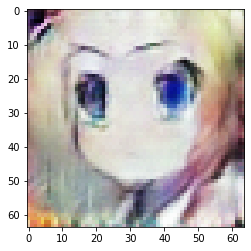

save product\407716646.png


In [33]:
product()

## 纳什均衡

GAN的训练问题一直被诟病，很容易出现训练不收敛和模式崩塌的现象。

本文实现的DCGAN也会出现这种情况，这时候调整超参数，如D和G的训练比例，学习率，激活函数等可能会有所帮助，
如何科学的调参呢？

首先要从理论层面进行分析，通过博弈学习的训练方式，**生成器G和判别器D分别会达到什么平衡状态**。

具体的，我们将探索一下两个问题：

<img src="balance.png" width="60%">

### 判别器状态

